In [1]:
"""
Use this notebook to train/test/evaluate Deep Learning for thread defect inspection

TRAINED ON GOOGLE COLAB PRO TO ENABLE GPUs and speed up training time
Now training locally on rtx3060 laptop

11/16 - trained on 2500 image/mask sets
11/16 - out of memory for 2500, changed to 2001
11/17 - UNET trained on 3090 64GB RAM, 1000 images OOM on 512x512. 
        Trained on 256x256, 25epochs with good results
        now 2500 images, larger batch 
        
11/20 - Addressed mask issue, now showing 7 classes instead of 9
      - fixed mask issue, now should have .bmp inputs, no need to crop and remove border

"""
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sys
print(sys.version)
from keras import layers
from tensorflow.keras.preprocessing.image import load_img
import cv2
import glob
import numpy as np

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print(gpus[0])

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
tf.test.is_built_with_cuda()
#print(os.getcwd())

True

In [3]:
#os.chdir("..")
#os.chdir(os. getcwd() + "\\src")
#from c import ROOT_DIR

#ROOT_DIR = 'C:\\Users\\Administrator\\Desktop\\DL_project_nov_10'

ROOT_DIR = 'C:\\Users\\endle\\Desktop\\dl - thread\\DL_project_nov_10'
os.chdir(ROOT_DIR)
print("current dir:", os.getcwd())


current dir: C:\Users\endle\Desktop\dl - thread\DL_project_nov_10


In [4]:
"""
Add Drive for dataset
"""
# local

mask_path = ROOT_DIR + "\\final_dataset\\masks\\"
image_path = ROOT_DIR + "\\final_dataset\\images\\"

""
SIZE_X = 256 #512  
SIZE_Y = 256 #512 
num_images = 2500
n_classes=7

In [5]:
"""updated image routine"""

image_names = glob.glob(image_path + "*.bmp")
image_names.sort()
image_names_subset = image_names[0:num_images]
#images = [cv2.imread(image, 0) for image in image_names_subset]

images = []

for image in image_names_subset:
    
    x = cv2.imread(image, cv2.COLOR_RGB2BGR)
    #x_n = x[2:579,13:590,:] # remove border
    #x_f = cv2.resize(x_n, (SIZE_X,SIZE_Y), 3, interpolation=cv2.INTER_NEAREST)
    #images.append(x_f)
    images.append(x)

image_dataset = np.array(images)
#image_dataset = np.expand_dims(image_dataset, axis = 3) #use for greyscale

print('shape of image_dataset', np.shape(image_dataset))

shape of image_dataset (2500, 256, 256, 3)


In [6]:
"""updated mask routine"""

mask_names = glob.glob(mask_path + "*.bmp")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]

masks = []

for mask in mask_names_subset:
    
    gt = cv2.imread(mask)
    #gray_n = gt[2:579,13:590] # crop out boundary
    #mask_f = cv2.resize(gray_n, (SIZE_X,SIZE_Y), interpolation=cv2.INTER_NEAREST)
    mask_c = np.nanmax(gt, axis=2) # collapse mask into 2D array.
    masks.append(mask_c)
    
print('shape of masks', np.shape(masks))

mask_dataset = np.array(masks) # should be: shape of masks (2612, 128, 128)

shape of masks (2500, 256, 256)


In [7]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (2500, 256, 256, 3)
Mask data shape is:  (2500, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4 5 6]


In [8]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

#"""
#ERROR look into this:
#
#C:\Users\Administrator\miniconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
#  y = column_or_1d(y, warn=True)
#
#"""

C:\Users\endle\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [9]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(2500, 256, 256, 1)


In [10]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler

In [11]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [12]:

from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [13]:
print(y_train_cat.shape)

(2000, 256, 256, 7)


In [14]:
"""
Updated UNET model, 512x512
"""
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [15]:
"""just jaccard index for loss """

from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

In [16]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print('input shape, ', input_shape)

input shape,  (256, 256, 3)


In [19]:
#model = build_unet(input_shape, n_classes=n_classes)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss=[jacard_coef_loss], metrics=[jacard_coef])
#model.summary()

img_size = (256, 256)
#img_size = (512, 512)

model = get_model(img_size, n_classes)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='jacard_coef_loss', metrics=['jacard_coef'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 32  128        ['conv2d_9[0][0]']               
 ormalization)                  )                                                           

 add_9 (Add)                    (None, 16, 16, 256)  0           ['max_pooling2d_5[0][0]',        
                                                                  'conv2d_12[0][0]']              
                                                                                                  
 activation_22 (Activation)     (None, 16, 16, 256)  0           ['add_9[0][0]']                  
                                                                                                  
 conv2d_transpose_8 (Conv2DTran  (None, 16, 16, 256)  590080     ['activation_22[0][0]']          
 spose)                                                                                           
                                                                                                  
 batch_normalization_22 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_transpose_8[0][0]']     
 ormalization)                                                                                    
          

 activation_28 (Activation)     (None, 128, 128, 64  0           ['add_12[0][0]']                 
                                )                                                                 
                                                                                                  
 conv2d_transpose_14 (Conv2DTra  (None, 128, 128, 32  18464      ['activation_28[0][0]']          
 nspose)                        )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 128, 128, 32  128        ['conv2d_transpose_14[0][0]']    
 ormalization)                  )                                                                 
                                                                                                  
 activation_29 (Activation)     (None, 128, 128, 32  0           ['batch_normalization_28[0][0]'] 
          

In [20]:
epochs = 100 # 50 was good
batch_size = 64 #32 was good

print('shape of X_train', np.shape(X_train))
print('shape of y_train_cat', np.shape(y_train_cat))
print('shape of X_test', np.shape(X_test))
print('shape of y_test_cat', np.shape(y_test_cat))

history = model.fit(X_train, y_train_cat, 
                    batch_size = batch_size, 
                    verbose=1, 
                    epochs=epochs, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

shape of X_train (2000, 256, 256, 3)
shape of y_train_cat (2000, 256, 256, 7)
shape of X_test (500, 256, 256, 3)
shape of y_test_cat (500, 256, 256, 7)
Epoch 1/100
32/32 [==============================] - 36s 897ms/step - loss: 0.5371 - accuracy: 0.9595 - val_loss: 0.2511 - val_accuracy: 0.9595
Epoch 2/100
32/32 [==============================] - 25s 781ms/step - loss: 0.0197 - accuracy: 0.9971 - val_loss: 0.2094 - val_accuracy: 0.9595
Epoch 3/100
32/32 [==============================] - 24s 760ms/step - loss: 0.0123 - accuracy: 0.9977 - val_loss: 0.2455 - val_accuracy: 0.9595
Epoch 4/100
32/32 [==============================] - 24s 747ms/step - loss: 0.0102 - accuracy: 0.9979 - val_loss: 0.2820 - val_accuracy: 0.9595
Epoch 5/100
32/32 [==============================] - 25s 783ms/step - loss: 0.0092 - accuracy: 0.9981 - val_loss: 0.3169 - val_accuracy: 0.9595
Epoch 6/100
32/32 [==============================] - 24s 745ms/step - loss: 0.0088 - accuracy: 0.9981 - val_loss: 0.3458 - val_a

32/32 [==============================] - 15s 465ms/step - loss: 0.0014 - accuracy: 0.9994 - val_loss: 0.0048 - val_accuracy: 0.9990
Epoch 57/100
32/32 [==============================] - 15s 481ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0048 - val_accuracy: 0.9991
Epoch 58/100
32/32 [==============================] - 15s 465ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0081 - val_accuracy: 0.9985
Epoch 59/100
32/32 [==============================] - 15s 465ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0055 - val_accuracy: 0.9989
Epoch 60/100
32/32 [==============================] - 15s 458ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0059 - val_accuracy: 0.9988
Epoch 61/100
32/32 [==============================] - 15s 465ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0053 - val_accuracy: 0.9989
Epoch 62/100
32/32 [==============================] - 18s 570ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0060 - val_accuracy: 0.998

In [22]:
#Save the model for future use

model_path = 'saved_model/UNET_256x256_20nov_2022_try2.hdf5'

model.save(model_path)

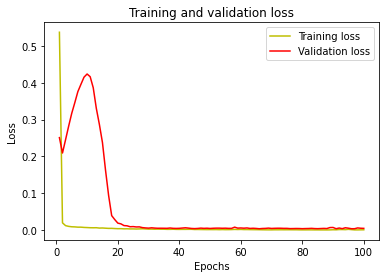

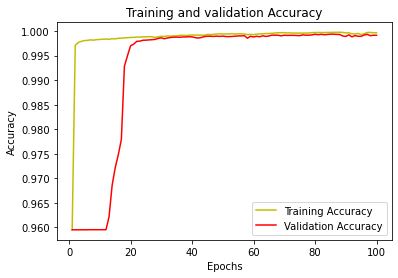

In [23]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
print('shpae of y_test cat', np.shape(y_test_cat))

print('shpae of y_test cat[0]', np.shape(y_test[0]))

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

shpae of y_test cat (500, 256, 256, 7)
shpae of y_test cat[0] (256, 256, 1)


shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 1s 723ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


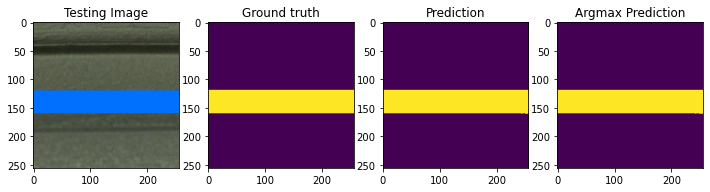

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 16ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


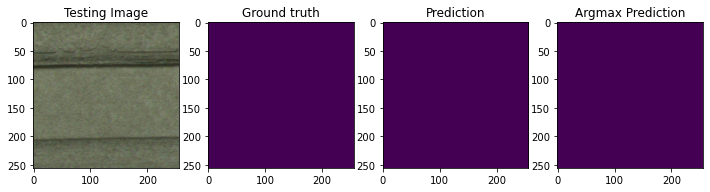

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 34ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


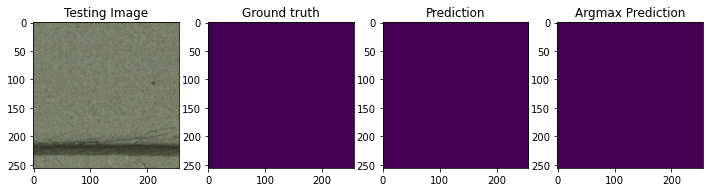

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 22ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


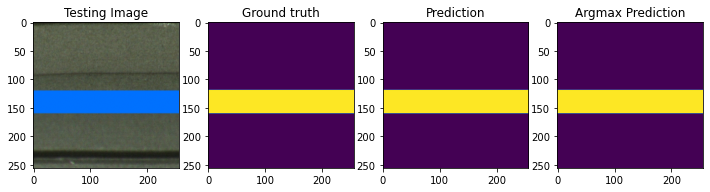

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 27ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


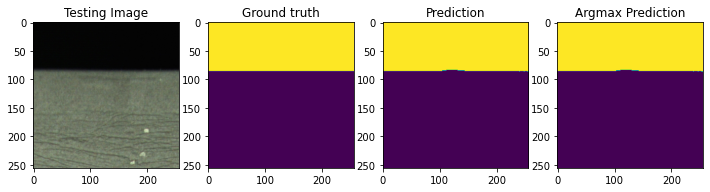

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 31ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


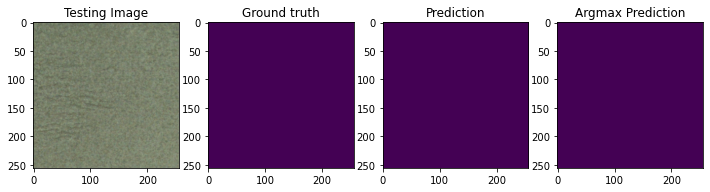

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


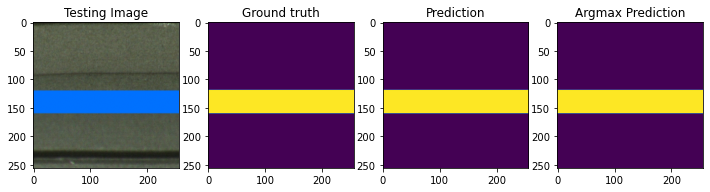

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 24ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


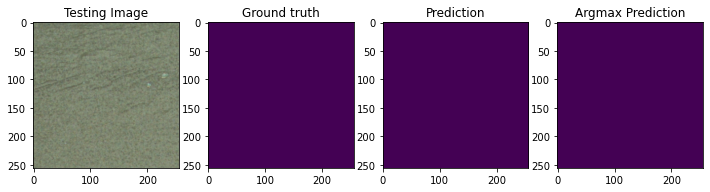

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


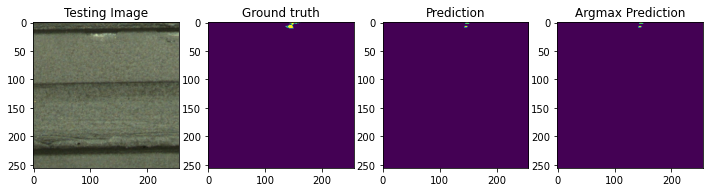

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


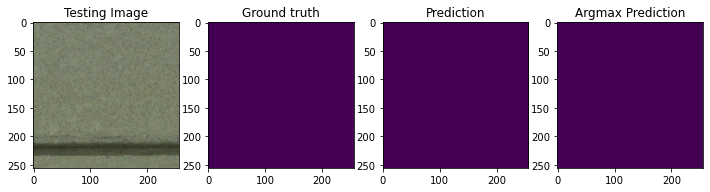

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 17ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


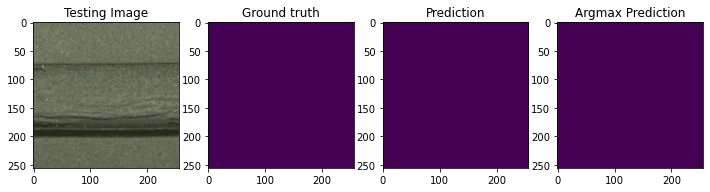

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 25ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


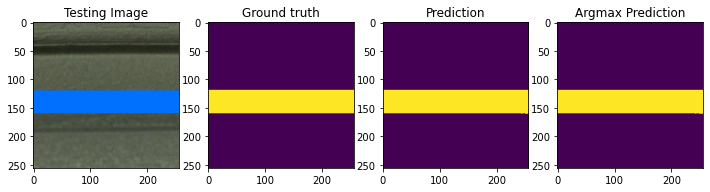

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 16ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


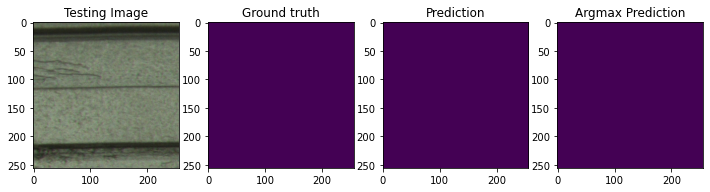

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 18ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


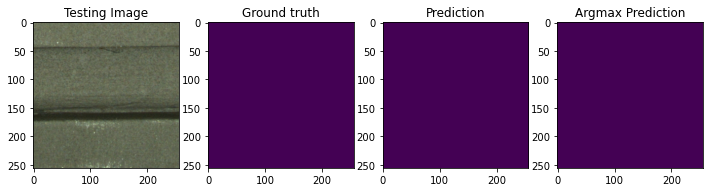

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


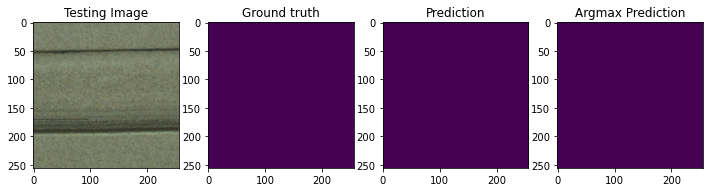

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 14ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


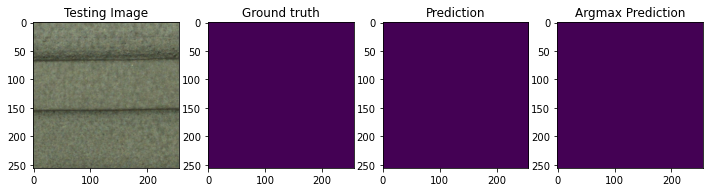

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 5ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


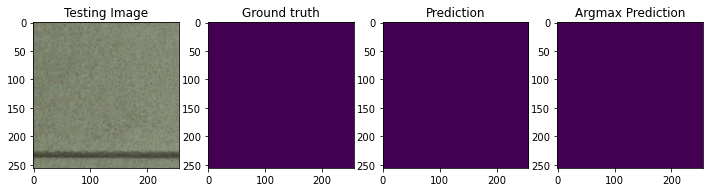

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 35ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


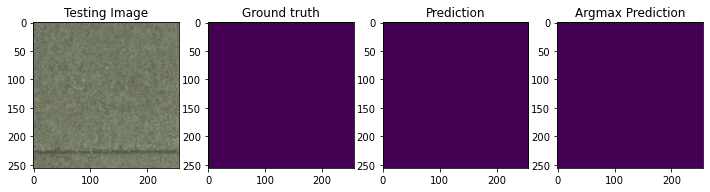

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 15ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


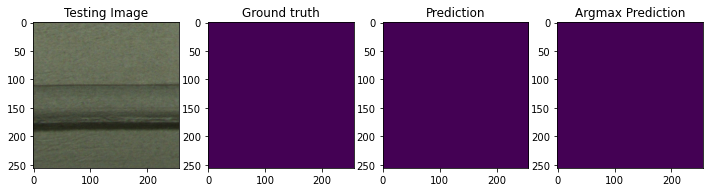

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 19ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


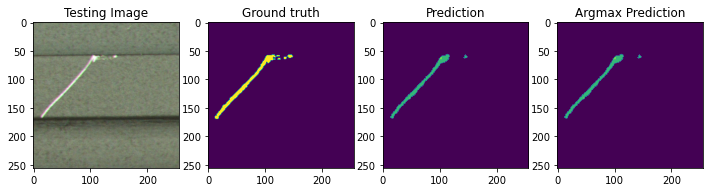

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 45ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


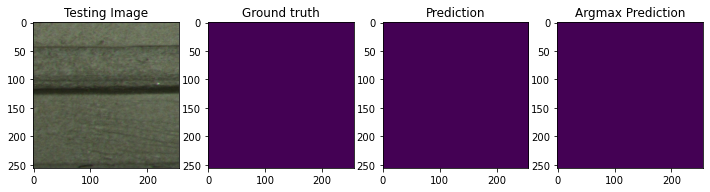

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 34ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


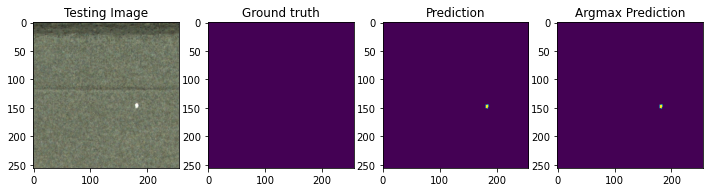

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 31ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


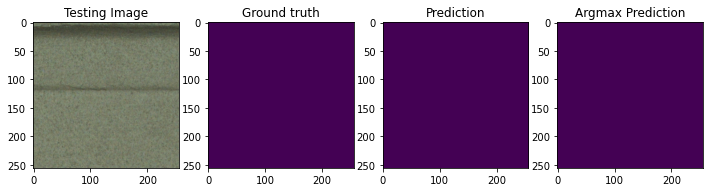

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 16ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


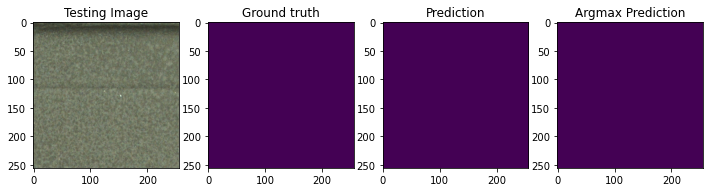

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 21ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


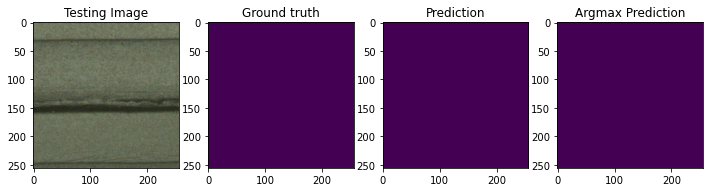

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 27ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


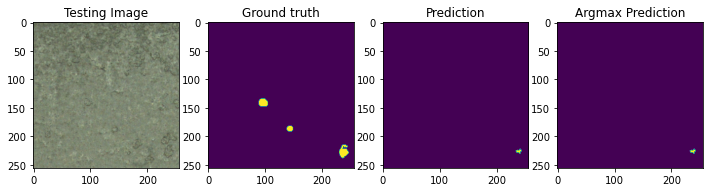

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 23ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


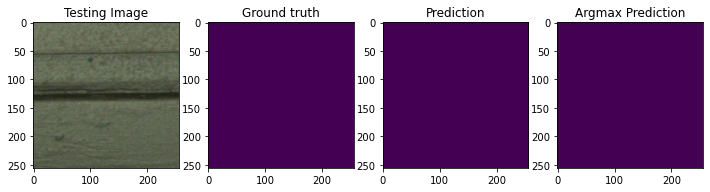

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


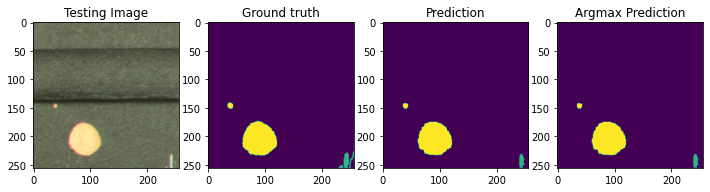

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 16ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


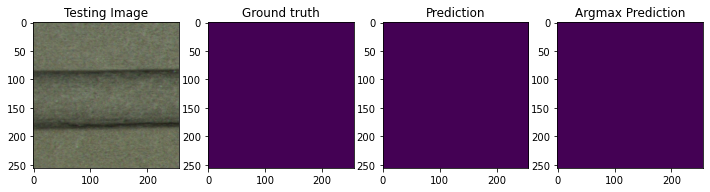

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 28ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


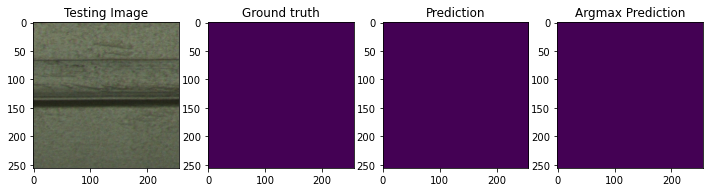

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 17ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


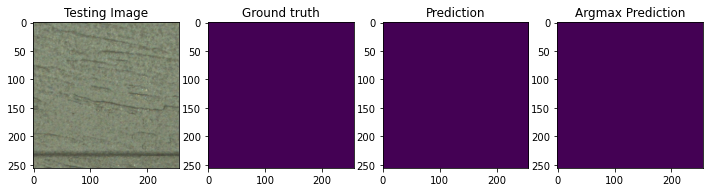

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


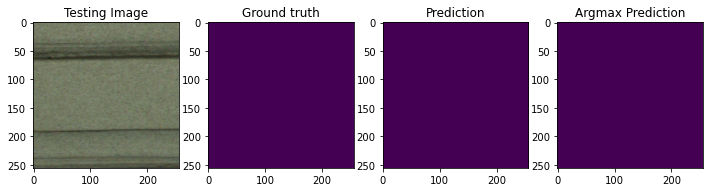

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 16ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


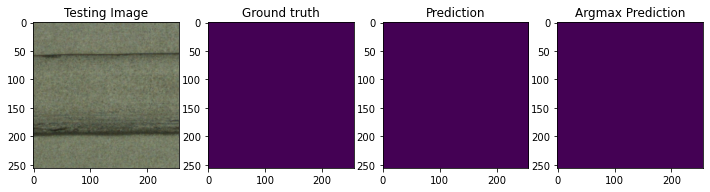

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 42ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


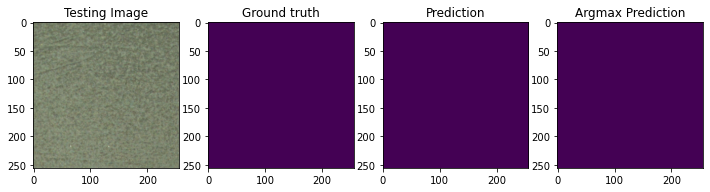

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 17ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


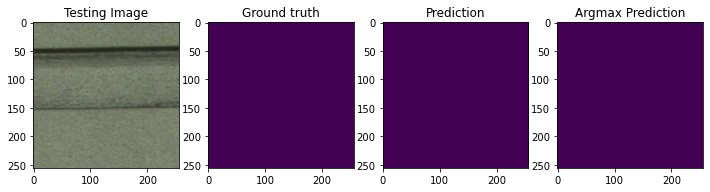

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 54ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


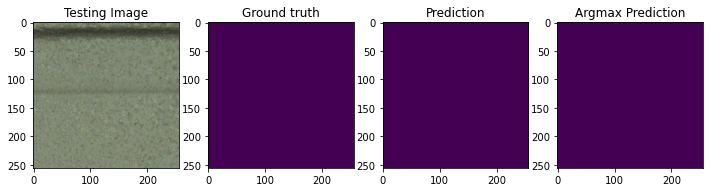

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 16ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


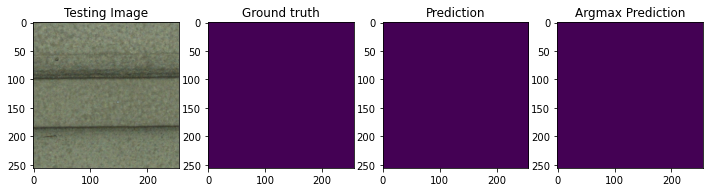

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 35ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


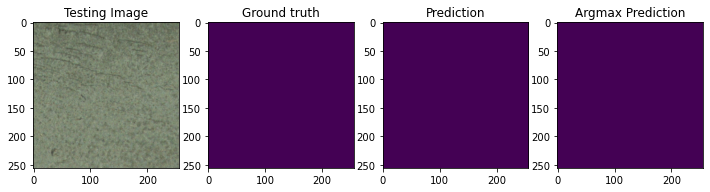

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


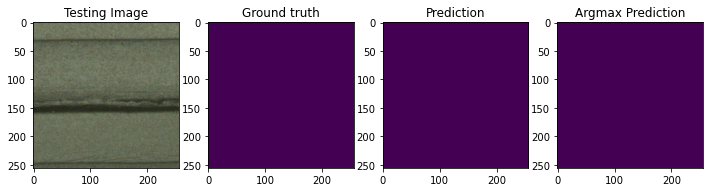

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 24ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


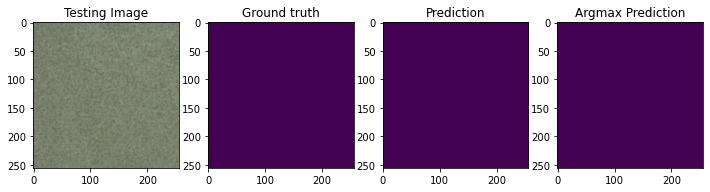

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 37ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


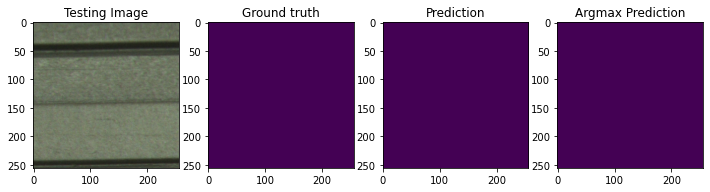

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 39ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


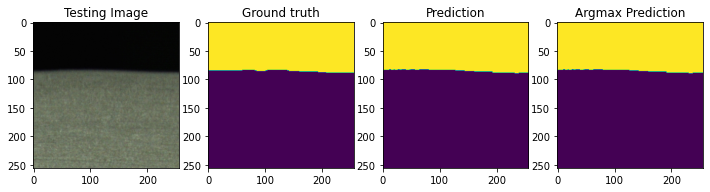

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 29ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


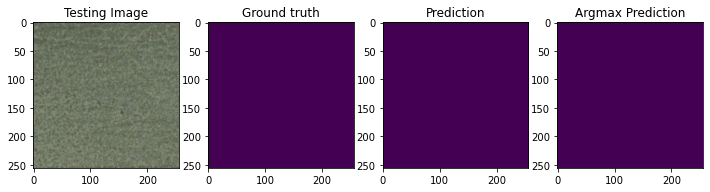

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 16ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


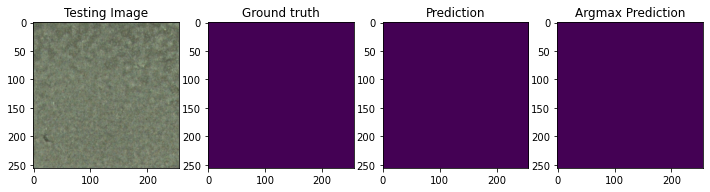

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 16ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


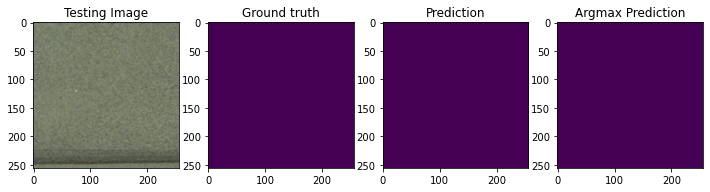

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 14ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


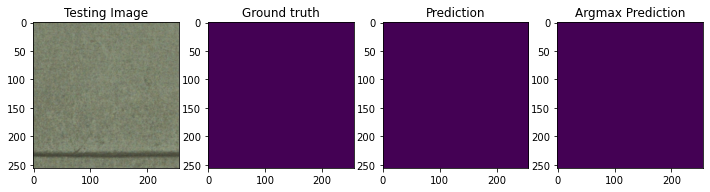

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 34ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


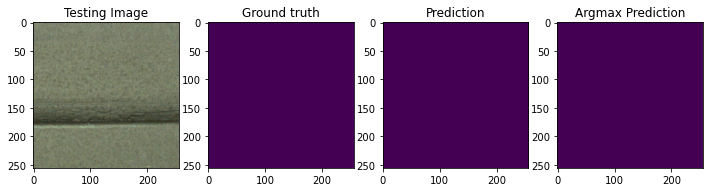

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 7ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


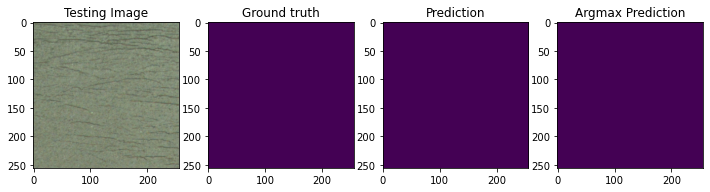

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 28ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


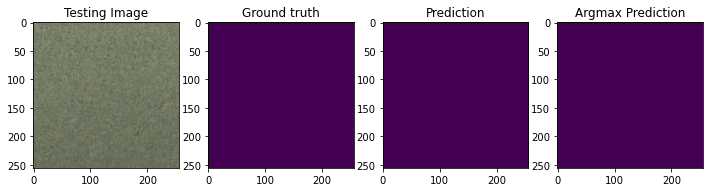

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 39ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


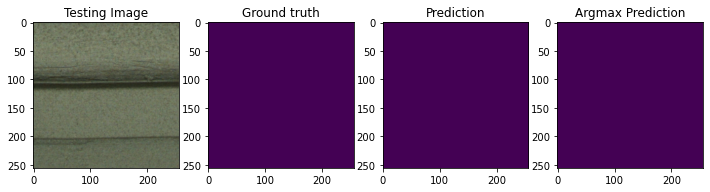

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 24ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


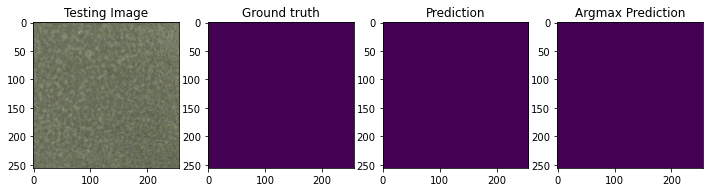

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 34ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


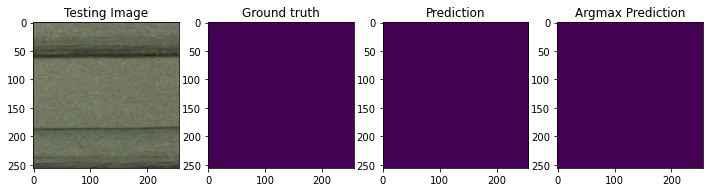

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 21ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


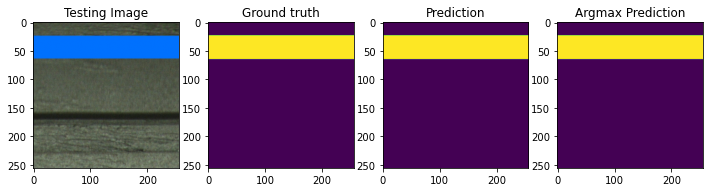

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 21ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


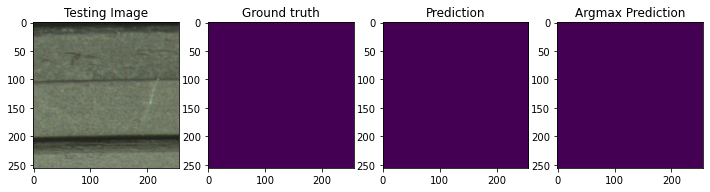

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 15ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


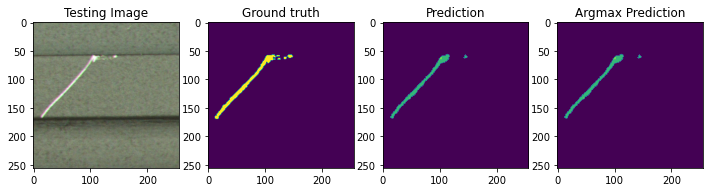

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


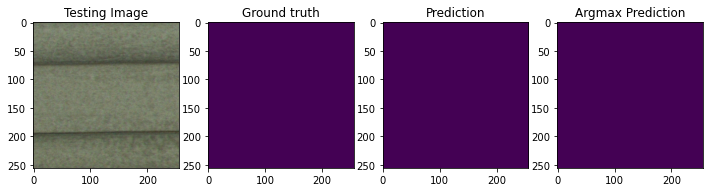

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 33ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


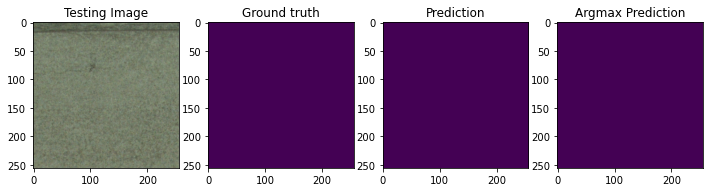

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 37ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


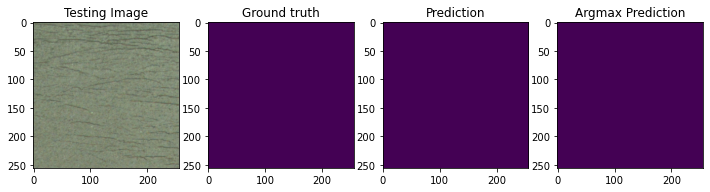

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 40ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


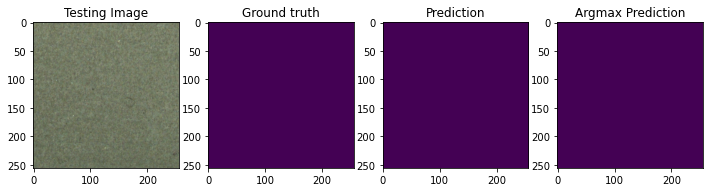

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 26ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


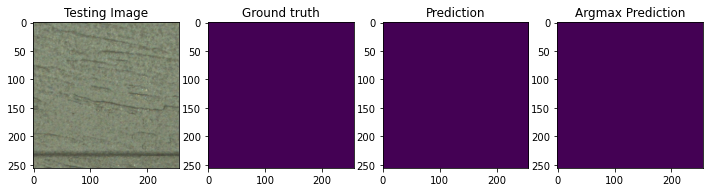

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 22ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


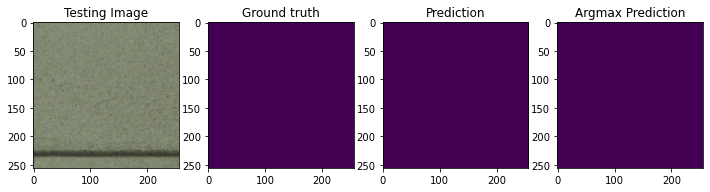

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 21ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


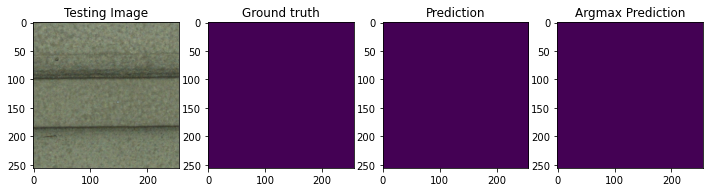

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 27ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


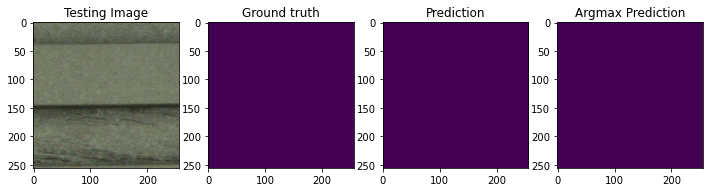

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 25ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


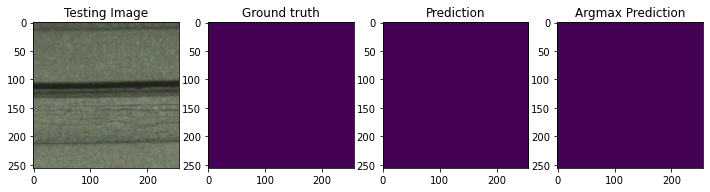

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 29ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


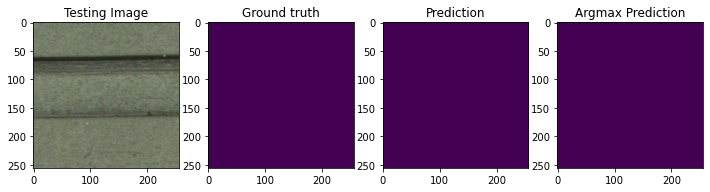

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 35ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


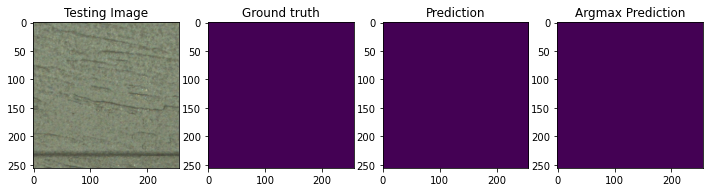

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 18ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


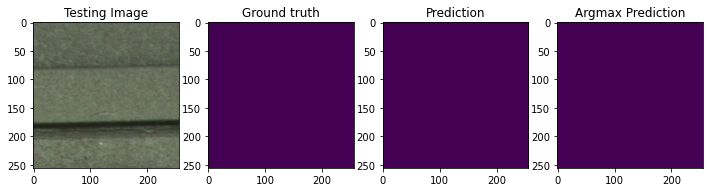

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 18ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


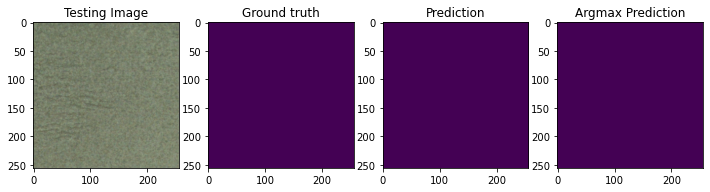

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 16ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


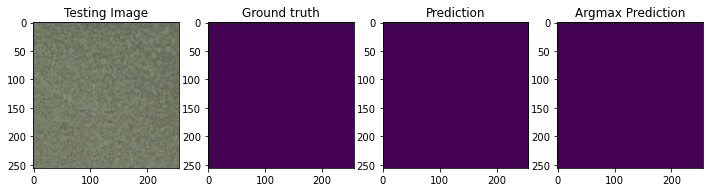

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 17ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


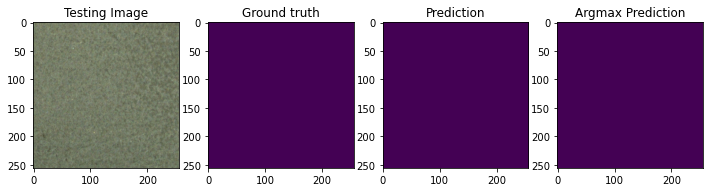

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 36ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


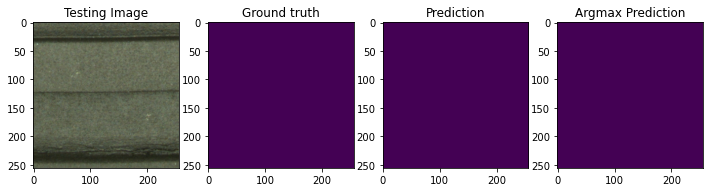

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 61ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


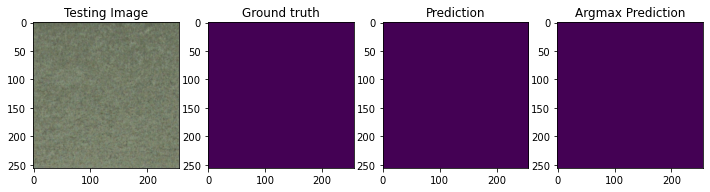

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 14ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


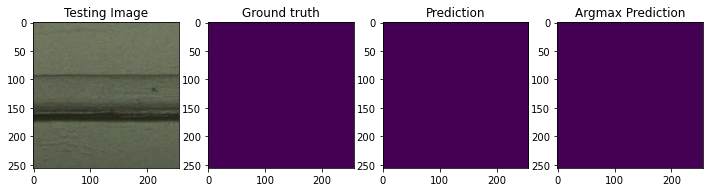

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 18ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


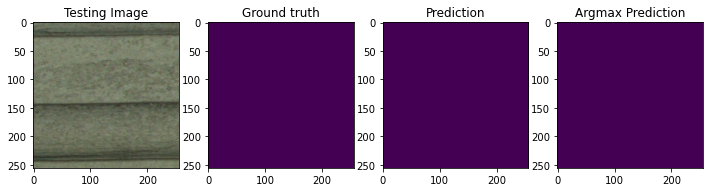

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 19ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


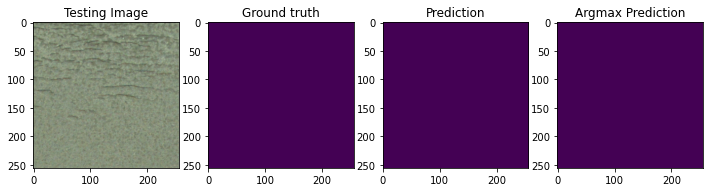

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 18ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


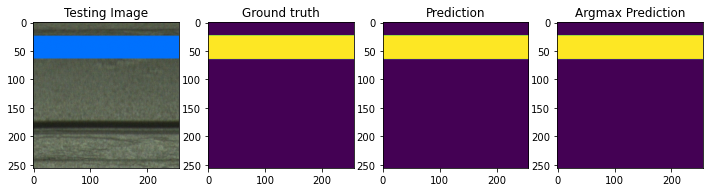

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 24ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


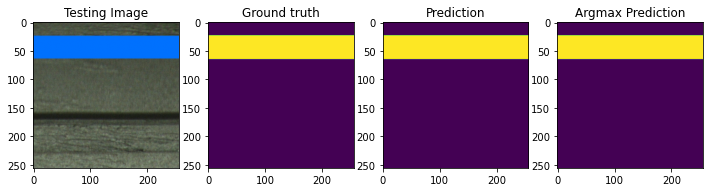

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


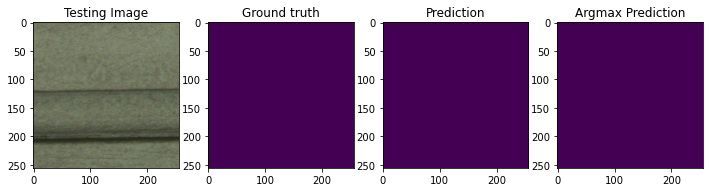

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 19ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


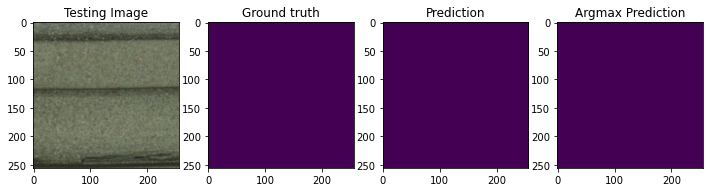

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 32ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


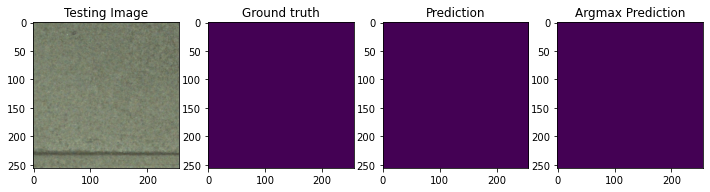

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 19ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


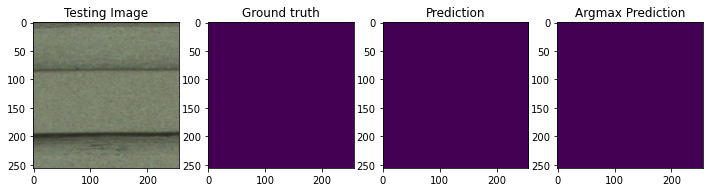

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 17ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


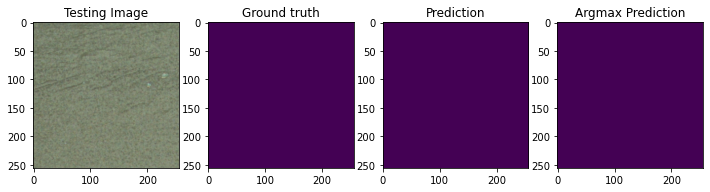

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 16ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


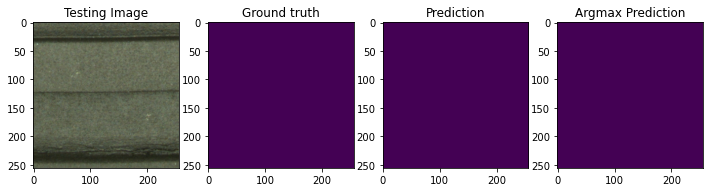

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 19ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


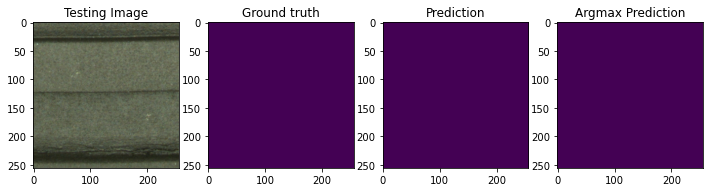

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 17ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


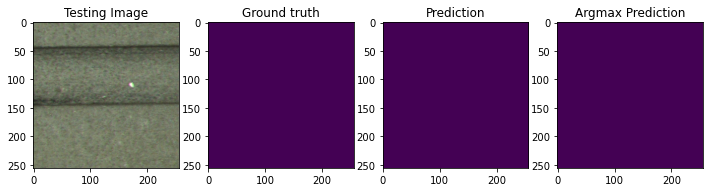

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


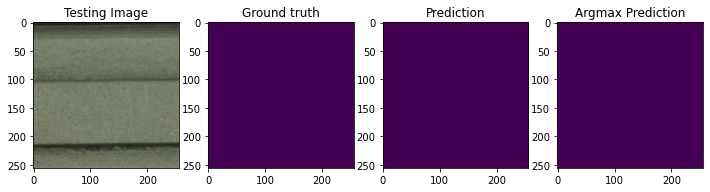

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 17ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


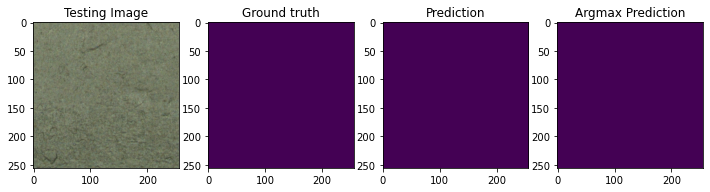

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 17ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


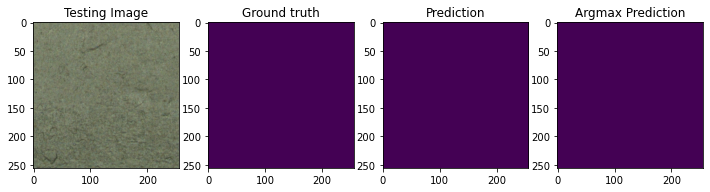

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 31ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


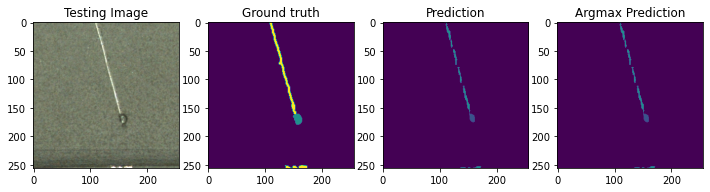

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 17ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


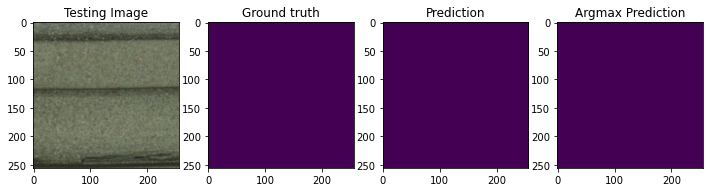

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 37ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


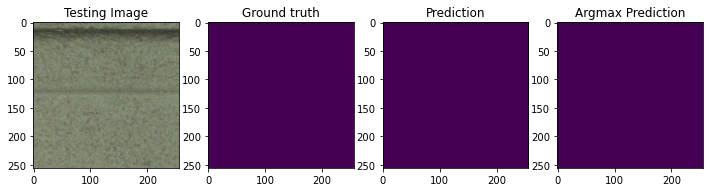

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 63ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


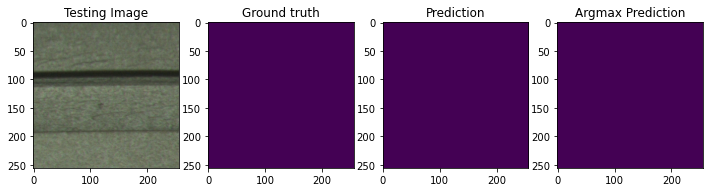

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 47ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


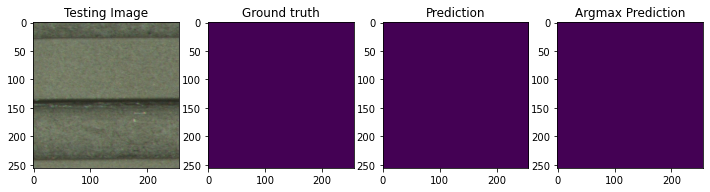

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 36ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


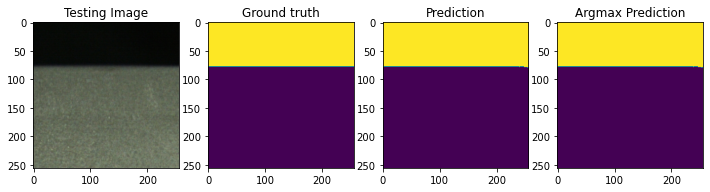

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 30ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


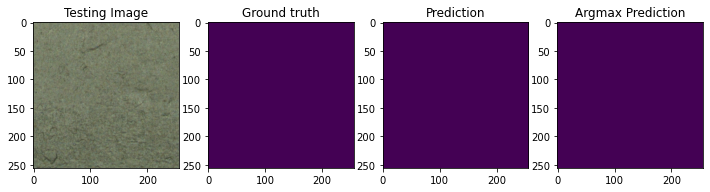

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 31ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


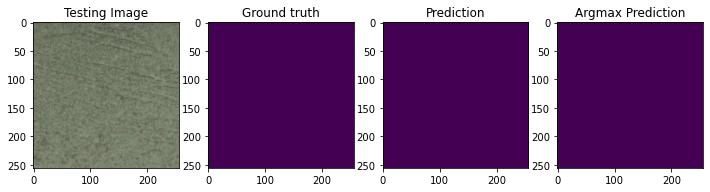

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 27ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


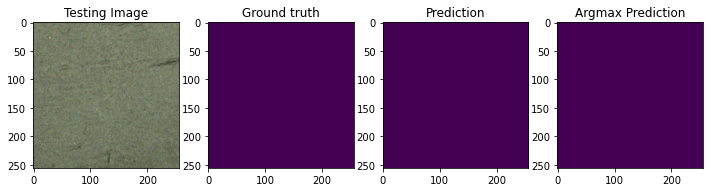

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 35ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


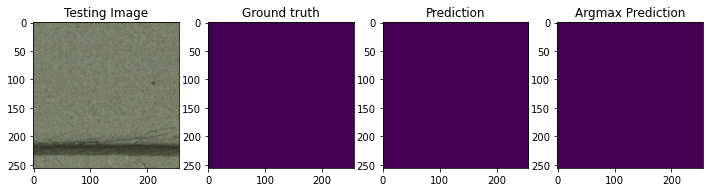

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 55ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


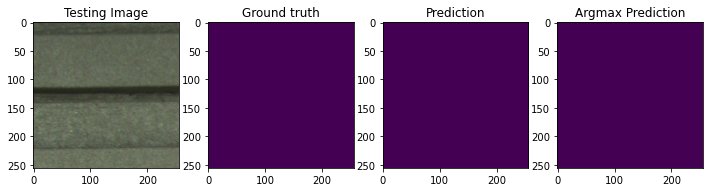

shape of reshaped (1, 256, 256, 3)
1/1 [==============================] - 0s 51ms/step
shape of pred (1, 256, 256, 7)
shape of mask_pred (256, 256, 1)


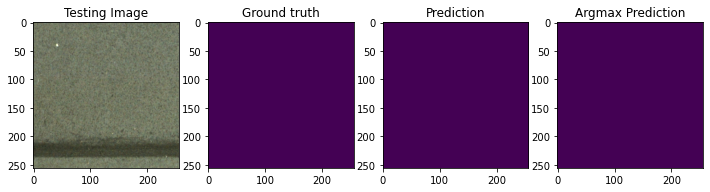

In [25]:
"""Look at results"""
import random

for i in range(100):

    #make it random

    j = random.randint(0, len(y_test_cat))
    
    X_test_r  = np.reshape(X_test[j],(-1,256,256,3))
    print('shape of reshaped', np.shape(X_test_r))

    y_pred=model.predict(X_test_r)

    print('shape of pred', np.shape(y_pred))

    print('shape of mask_pred', np.shape(create_mask(y_pred)))

    plt.figure(figsize=(12, 8))
    
    plt.subplot(141)
    plt.imshow(X_test[j])
    plt.title('Testing Image')

    plt.subplot(142)
    plt.imshow(y_test[j])
    plt.title('Ground truth')

    plt.subplot(143)
    plt.imshow(create_mask(y_pred))

    
    plt.title('Prediction')

    plt.subplot(144)
    y_pred_argmax=np.argmax(y_pred, axis=3)
    plt.imshow(y_pred_argmax[0])
    plt.title('Argmax Prediction')

    # gt = y_test_cat[0]
    # pd = y_pred_argmax[0]

    # gt_g = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)


    # print('shapes', np.shape(gt), np.shape(pd))
    # print('shapes', np.shape(gt_g), np.shape(pd))
    
    # diff = gt_g - pd
    # #s_index = similarity_index(gt_g, pd,IMG_HEIGHT, IMG_WIDTH)

    # plt.show()

    # plt.imshow(diff)

    # print('sum of diff, ', np.sum(diff))
    plt.show()

    #print('sim index: ', s_index)

In [ ]:
## OLD ##

In [ ]:
"""
Our dataloader
"""

input_dir = image_path
target_dir = mask_path

input_img_paths = sorted(
    [
        os.path.join(os.sep, input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(os.sep, target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

In [ ]:
class ThreadInspectionDataLoader(keras.utils.Sequence):
    """
    Helper to iterate over data as Numpy arrays.
    https://keras.io/examples/vision/oxford_pets_image_segmentation/

    """

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, n_classes):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.n_classes = n_classes

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def one_hot_data(self, image):
    
        # reduce unique values down to number of classes
        result = self.kmeans_color_quantization(image, clusters=3) # should spit out 8
        result_g = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        one_hot = np.zeros((result.shape[0], result.shape[1], self.n_classes))
        for i, unique_value in enumerate(np.unique(result_g)):

            one_hot[:, :, i][result_g == unique_value] = 1

        return one_hot
    
    def kmeans_color_quantization(self, image, clusters=8, rounds=1):
        h, w = image.shape[:2]
        samples = np.zeros([h*w,3], dtype=np.float32)
        count = 0

        for x in range(h):
            for y in range(w):
                samples[count] = image[x][y]
                count += 1

        compactness, labels, centers = cv2.kmeans(samples,
                clusters, 
                None,
                (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
                rounds, 
                cv2.KMEANS_RANDOM_CENTERS)

        centers = np.uint8(centers)
        res = centers[labels.flatten()]
        return res.reshape((image.shape))
    
    def __getitem__(self, idx):

        """Returns tuple (input, target) correspond to batch #idx."""

        i = idx * self.batch_size
        
        h = self.img_size[0]
        w = self.img_size[1]
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")

        for j, path in enumerate(batch_input_img_paths):

            img = cv2.imread(path)
            
            height = img.shape[0]
            width = img.shape[1]
            channels = img.shape[2]
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (self.n_classes,), dtype="float32")

        for j, path in enumerate(batch_target_img_paths):
            
            img = cv2.imread(path)
            
            height = img.shape[0]
            width = img.shape[1]
            channels = img.shape[2]
            y[j] = self.one_hot_data(img)
            
        #print(np.shape(x), np.shape(y))
        
        return x, y

In [ ]:
import random

#img_size = (256, 256) # a lot faster!
img_size = (512, 512) # not as fast, but accurate

num_classes = 7
batch_size = 4 # 2 prior #4 #8 deafult #, 16 worked well for 256,256 ...32 before, OOM

# Split our img paths into a training and a validation set
val_samples = 500 #500 #100 before
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = ThreadInspectionDataLoader(batch_size, img_size, train_input_img_paths, train_target_img_paths, num_classes)
val_gen = ThreadInspectionDataLoader(batch_size, img_size, val_input_img_paths, val_target_img_paths, num_classes)

In [ ]:
model = seg_hrnet(batch_size, img_size[0], img_size[1], 3, num_classes)
model.summary()
# model.load_weights('seg_hrnet-08-4.2117-0.9428-0.4832.hdf5')

In [ ]:

# # training params
GPUs = '0, 1, 2, 3'
os.environ["CUDA_VISIBLE_DEVICES"] = GPUs
Optimizer = 'Adam'  # SGD(lr=0.01, momentum=0.9, nesterov=True)
#Loss = ce_jaccard_loss
#Metrics = ['accuracy', iou]
#Metrics = iou

# NumEpochs = 100
# Patience = 10

 # visualization params
metric_list = ['acc', 'iou']


callbacks = [
    keras.callbacks.ModelCheckpoint("hrnet_segmentation.h5", save_best_only=True)
]

## tensorflow defined loss and metric

#miou = tf.keras.metrics.MeanIoU(num_classes=3, name='miou', dtype=None)
loss = ce_jaccard_loss
metric = iou
#metric = tf.keras.metrics.MeanIoU(num_classes=3)
epochs = 100 #100 #200
#model.compile(optimizer='Adam', loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)], metrics=[tf.keras.metrics.MeanIoU(num_classes=3)])
model.compile(optimizer='Adam', loss=loss, metrics=metric)



In [ ]:
#result = model.fit(train_gen, epochs = epochs, validation_data=val_gen, verbose = 1, use_multiprocessing = True, workers = 32 )
#result = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
result = model.fit(train_gen, epochs = epochs, validation_data=val_gen, verbose = 1)


In [ ]:
"""
Show results
"""

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(result.epoch, result.history['iou'], label='iou')
plt.scatter(result.epoch, result.history['iou'], marker='*')
plt.plot(result.epoch, result.history['val_iou'], label='val_iou')
plt.scatter(result.epoch, result.history['val_iou'], marker='*')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('iou')
plt.title('iou over 100 epochs')

plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(result.epoch, result.history['loss'], label="loss")
plt.plot(result.epoch, result.history['val_loss'], label="val_loss")
plt.scatter(result.epoch, result.history['loss'], marker='*')
plt.scatter(result.epoch, result.history['val_loss'], marker='*')
plt.legend(loc='upper right')
plt.ylim([0,5])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over 100 epochs')

plt.show()

In [ ]:
"""
Show results
"""

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(result.epoch, result.history['acc'], label='acc')
plt.scatter(result.epoch, result.history['acc'], marker='*')
plt.plot(result.epoch, result.history['val_acc'], label='val_acc')
plt.scatter(result.epoch, result.history['val_acc'], marker='*')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('acc over 50 epochs')

plt.show()

In [ ]:
# register custom functions to model, so it can be saved and loaded

# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"loss": ce_jaccard_loss, "metrics": iou}
#with keras.utils.custom_object_scope(custom_objects):
#    new_model = keras.Model.from_config(config)

In [ ]:
# save model
#!mkdir -p saved_model
print(os.getcwd())
#!model.save('saved_model/DAS_HR_512_model_25epochs.hdf5')
model.save('saved_model/DAS_HR_512_uncond_model_100epochs_sept15.hdf5')

In [ ]:
# tweak rgb thresholds to match prediction with masks

s = 512

def make_mask(pred):
    """ take prediction, each layer is a rbg channel"""

    r = pred[:,:,:,0]
    g = pred[:,:,:,1]
    b = pred[:,:,:,2]

    r_m = np.nanmax(r)
    g_m = np.nanmax(g)
    b_m = np.nanmax(b)

    n_r = (r/r_m).reshape((s,s))
    n_g = (g/g_m).reshape((s,s))
    n_b = (b/b_m).reshape((s,s))

    # set thresholds, manually...

    # n_r[n_r < .65] = 0 #.75
    # n_g[n_g < .66] = 0 #.66
    # n_b[n_b < .47] = 0 #.47

    n_r[n_r > .99] = 0 #.85
    n_g[n_g > .99] = 0 #.85
    n_b[n_b > .99] = 0 #.85

    #n_r[n_r > .90] = 0 #.85
    #n_g[n_g > .90] = 0 #.85
    #n_b[n_b > .90] = 0 #.85


    #return np.dstack((n_r,n_g,n_b))
    return np.dstack((n_r,n_g,n_b))

# test on first 10 random images

for i in range(1,30):

    j = random.randint(0, len(input_img_paths))

    f, axs = plt.subplots(1,3, figsize=(20,20))
    
    eg_file_img = '{}.png'.format(i)
    
    i_path = image_path + eg_file_img
    m_path = mask_path + eg_file_img

    #print('path', i_path)

    #img = cv2.imread(i_path, cv2.COLOR_BGR2RGB)
    #mask = cv2.imread(m_path, cv2.COLOR_BGR2RGB)

    img = cv2.imread(i_path)
    mask = cv2.imread(m_path)
    x = img
    #print('shape of image', np.shape(x))
    
    axs[0].imshow(x)
    axs[2].imshow(x)

    m = mask
    x = x.reshape(1,s,s,3)
    p = model.predict(x)

    axs[1].imshow(m)
    
    axs[2].imshow(make_mask(p), alpha=0.5)

    axs[0].set_title('GT for ' +str(j))
    axs[1].set_title('Mask')
    axs[2].set_title('Prediction with GT overlay')

    plt.show()

In [ ]:
while True:pass
